<a href="https://colab.research.google.com/github/Francesco0101/Computer-Vision-Project-on-Ground-To-Aerial-Matching/blob/main/CV_project_on_Cross_image_matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import

In [1]:
%%capture
!pip install gdown
!pip install rarfile
!pip install datasets opencv-contrib-python opencv-python ipywidgets scipy
!pip install pytorch_lightning
!pip install pytorch_lightning

In [42]:
import gdown
import zipfile
import os
from google.colab.patches import cv2_imshow #rimuovere se online
import cv2
from tqdm import tqdm
import numpy as np
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pytorch_lightning as pl
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import pytorch_lightning as pl
from torch.utils.data import random_split
import logging
from collections import OrderedDict
import torchvision
from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
from torch import optim
from torch.utils.data.distributed import DistributedSampler
from pytorch_lightning.callbacks.progress import RichProgressBar
import matplotlib.pyplot as plt
from pytorch_lightning import seed_everything, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
torch.set_float32_matmul_precision('medium') # solo in locale

#University Dataset da cambiare

In [ ]:
!wget -O file.zip 'https://drive.google.com/file/d/17W9VEPMneRlb6igtSxa--Xh4fSZs3RS_/view?usp=sharing' #Download dataset


In [ ]:

# Percorso del file zip
file_zip = "dataset.zip"

# Percorso di destinazione per l'estrazione
percorso_estrazione = "/content"

# Estrai il file zip
with zipfile.ZipFile(file_zip, 'r') as zip_ref:
    zip_ref.extractall(percorso_estrazione)

# Mostra i file estratti
print("File estratti in:", percorso_estrazione)
print("Elenco dei file estratti:")
for file in os.listdir(percorso_estrazione):
    print(file)

#CVUSA Dataset

To load directly without drive

In [ ]:
"""

!pip install rarfile
!gdown --id 17W9VEPMneRlb6igtSxa--Xh4fSZs3RS_

"""

'\n\n!pip install rarfile\n!gdown --id 17W9VEPMneRlb6igtSxa--Xh4fSZs3RS_\n\n'

In [ ]:
# import rarfile
# import os

# # Percorso del file RAR
# file_rar = "/content/drive/MyDrive/CV/CVUSA_subset.rar"

# # Directory di destinazione per l'estrazione
# extract_path = "/content/CVUSA_subset"

# # Estrarre il file RAR
# with rarfile.RarFile(file_rar, 'r') as rar:
#     # Crea la directory di destinazione se non esiste
#     os.makedirs(extract_path, exist_ok=True)
#     # Estrai tutto nella directory di destinazione
#     rar.extractall(extract_path)

# print("Estrazione completata.")

In [13]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


##Needed Paths

In [111]:
# Percorsi delle directory
import re
#Francesco
bingmap_dir = '/content/drive/MyDrive/CVUSA_subset/bingmap'
streetview_dir = '/content/drive/MyDrive/CVUSA_subset/streetview'
cvusa_dir = '/content/drive/MyDrive/CVUSA_subset'
csv_path = 'file_paths.csv'
bingmap_files = sorted(os.listdir(bingmap_dir))
streetview_files = sorted(os.listdir(streetview_dir))
#Simone
# bingmap_dir = 'CVUSA_subset/bingmap'
# streetview_dir = 'CVUSA_subset/streetview'
# bingmap_sift_dir = 'CVUSA_subset/sift/bingmap'
# streetview_sift_dir = 'CVUSA_subset/sift/streetview'
# cvusa_dir = 'CVUSA_subset'
# csv_path = 'CVUSA_subset/file_paths.csv'

In [22]:
import csv

# Define input and output file paths
input_csv = 'file_paths.csv'
output_csv = 'updated_output_file.csv'

# Prepend this prefix to each sample path
prefix = "drive/MyDrive"

# Open input and output files
with open(input_csv, 'r') as csvfile, open(output_csv, 'w', newline='') as outfile:
    reader = csv.reader(csvfile)
    writer = csv.writer(outfile)

    # Iterate over each row in the input CSV
    for row in reader:
        updated_row = []
        for col in row:
            updated_col = f"{prefix}/{col}"
            updated_row.append(updated_col)
        writer.writerow(updated_row)

print(f"Updated CSV file written to {output_csv}")


Updated CSV file written to updated_output_file.csv


##SIFT DETECTOR


In [118]:
import cv2
import numpy as np
import os
from tqdm import tqdm

# Definisci le liste per salvare i descrittori
Aerial_sift = []
Ground_sift = []

def extract_sift_descriptor(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    sift = cv2.SIFT_create()

    keypoints, descriptors = sift.detectAndCompute(image, None)

    if descriptors is not None:
        return descriptors
    else:
        print("No descriptors found.")
        return None

# Esempio di utilizzo per estrarre e salvare i descrittori SIFT

for file in tqdm(bingmap_files):
    if file.endswith(".png"):
        image_path = os.path.join(bingmap_dir, file)
        sift_descriptor = extract_sift_descriptor(image_path)
        if sift_descriptor is not None:
            Aerial_sift.append(sift_descriptor)
            # Salva i descrittori nel file npy
            np.savez_compressed(f"drive/MyDrive/CVUSA_subset/sift/bingmap/sift_descriptors_{file[:-4]}.npz", sift_descriptor)
            # print(f"Saved compressed SIFT descriptors for {file}")
            # np.save(f"/sift/bingmap/sift_descriptors_{file[:-4]}.npy", sift_descriptor)
            # print(f"Saved SIFT descriptors for {file}")

# Ora Aerial_sift contiene tutti i descrittori SIFT estratti, e sono stati salvati su disco.



  0%|          | 12/8862 [00:03<40:13,  3.67it/s]


KeyboardInterrupt: 

In [116]:
# import numpy as np

# # Esempio di caricamento dei descrittori SIFT da un file .npz
# file_path = "drive/MyDrive/CVUSA_subset/sift/bingmap/sift_descriptors_input0000008.npz"

# # Carica il file .npz
# data = np.load(file_path)

# # Estrai i descrittori
# sift_descriptors = data['arr_0']  # La chiave 'arr_0' è il nome predefinito per l'array salvato

# print(sift_descriptors)

[[ 7.  0.  0. ...  8.  0.  0.]
 [ 0.  0.  0. ... 22.  7. 36.]
 [ 0.  1.  5. ...  0. 18. 76.]
 ...
 [ 0.  0.  0. ...  0.  2.  8.]
 [95. 21.  4. ...  8.  1.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]


In [ ]:
for file in tqdm(streetview_files):
    if file.endswith(".jpg"):
        image_path = os.path.join(streetview_dir, file)
        sift_descriptor = extract_sift_descriptor(image_path)
        if sift_descriptor is not None:
            Aerial_sift.append(sift_descriptor)
            # Salva i descrittori nel file npy
            np.save(f"/sift/streetview/sift_descriptors_{file[:-4]}.npy", sift_descriptor)
            # print(f"Saved SIFT descriptors for {file}")

 75%|██████████████████████████████████████████████████████████▍                   | 6644/8862 [11:15<03:07, 11.84it/s]

No descriptors found.


100%|██████████████████████████████████████████████████████████████████████████████| 8862/8862 [15:26<00:00,  9.56it/s]


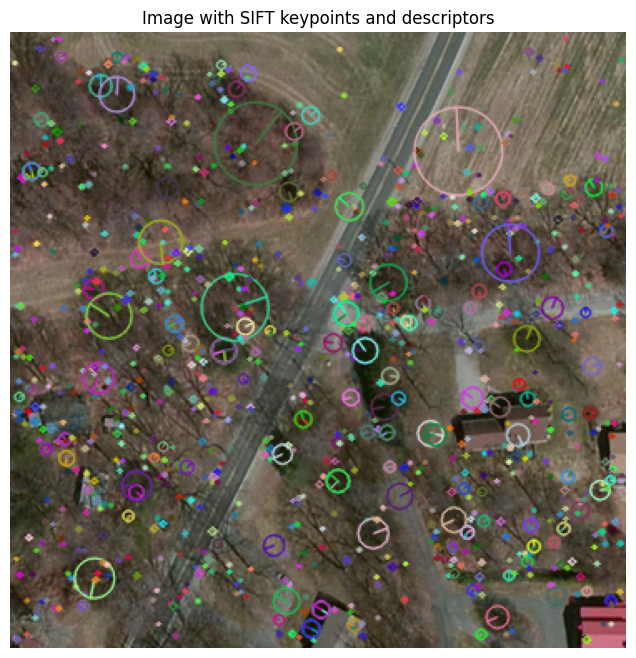

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Funzione per caricare l'immagine con keypoints e descrittori SIFT sovrapposti
def visualize_sift(image_path, sift_descriptor_path):
    # Carica l'immagine originale
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Converti da BGR (OpenCV) a RGB (Matplotlib)

    # Carica i descrittori SIFT dal file .npy
    sift_descriptor = np.load(sift_descriptor_path)

    # Crea l'oggetto SIFT
    sift = cv2.SIFT_create()

    # Trova keypoints e calcola i descrittori
    keypoints, descriptors = sift.detectAndCompute(image, None)

    # Disegna i keypoints e i descrittori SIFT sull'immagine
    image_with_sift = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    # Visualizza l'immagine con i keypoints e i descrittori sovrapposti
    plt.figure(figsize=(10, 8))
    plt.imshow(image_with_sift)
    plt.title('Image with SIFT keypoints and descriptors')
    plt.axis('off')
    plt.show()

# Esempio di utilizzo
image_path = "/CVUSA_subset/bingmap/input0000008.png"
sift_descriptor_path = "/sift/bingmap/sift_descriptors_input0000008.npy"

visualize_sift(image_path, sift_descriptor_path)


In [ ]:
import numpy as np

# Esempio di caricamento di un descriptor SIFT da un file .npy
filename = "/sift/bingmap/sift_descriptors_input0000008.npy"  # Assicurati di specificare il percorso completo se non è nello stesso script

# Carica il descriptor SIFT dal file .npy
sift_descriptor = np.load(filename)

# Ora puoi utilizzare il descriptor SIFT per qualsiasi operazione desideri
print("Shape of loaded descriptor:", sift_descriptor.shape)
print("Example of loaded descriptor:", sift_descriptor[:10])  # Esempio di stampa dei primi 10 elementi del descriptor

Shape of loaded descriptor: (1143, 128)
Example of loaded descriptor: [[ 7.  0.  0. ...  8.  0.  0.]
 [ 0.  0.  0. ... 22.  7. 36.]
 [ 0.  1.  5. ...  0. 18. 76.]
 ...
 [82. 35.  9. ...  3.  5.  0.]
 [ 6. 13.  2. ... 53.  7.  3.]
 [33. 31. 27. ... 28. 78. 51.]]


##CSV creation

In [ ]:

# Function to extract numeric identifier from filenames
def extract_identifier(filename):
    match = re.search(r'\d+', filename)
    return match.group() if match else None

# Read files from directories
bingmap_files = sorted(os.listdir(bingmap_dir))
streetview_files = sorted(os.listdir(streetview_dir))
bingmap_sift_files = sorted(os.listdir(bingmap_sift_dir))
streetview_sift_files = sorted(os.listdir(streetview_sift_dir))

print(len(bingmap_files))
print(len(streetview_files))
print(len(bingmap_sift_files))
print(len(streetview_sift_files))



# Create dictionaries to map identifiers to filenames
bingmap_dict = {extract_identifier(f): f for f in bingmap_files}
streetview_dict = {extract_identifier(f): f for f in streetview_files}
bingmap_sift_dict = {extract_identifier(f): f for f in bingmap_sift_files}
streetview_sift_dict = {extract_identifier(f): f for f in streetview_sift_files}

# Find all identifiers
all_identifiers = set(bingmap_dict.keys()).union(streetview_dict.keys(), bingmap_sift_dict.keys(), streetview_sift_dict.keys())

# Write file paths to CSV
with open(csv_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    for identifier in all_identifiers:
        bingmap_file = bingmap_dict.get(identifier, "None")
        streetview_file = streetview_dict.get(identifier, "None")
        bingmap_sift_file = bingmap_sift_dict.get(identifier, "None")
        streetview_sift_file = streetview_sift_dict.get(identifier, "None")

        bingmap_path = f"{bingmap_dir}/{bingmap_file}" if bingmap_file != "None" else "None"
        streetview_path = f"{streetview_dir}/{streetview_file}" if streetview_file != "None" else "None"
        bingmap_sift_path = f"{bingmap_sift_dir}/{bingmap_sift_file}" if bingmap_sift_file != "None" else "None"
        streetview_sift_path = f"{streetview_sift_dir}/{streetview_sift_file}" if streetview_sift_file != "None" else "None"

        writer.writerow([bingmap_path, streetview_path, bingmap_sift_path, streetview_sift_path])

print(f"CSV creato con successo in {csv_path}")

8862
8862
8855
8861
CSV creato con successo in CVUSA_subset/file_paths.csv


# Dataset

In [83]:
class CVUSADatasetPath(Dataset):
    def __init__(self, cvusa_dir, directory):
        self.directory = directory
        self.cvusa_dir = cvusa_dir
        self.aerial_paths = []
        self.ground_paths = []
        self.aerial_sift_paths = []
        self.ground_sift_paths = []

        with open(self.directory, mode='r') as file:
          csv_reader = csv.reader(file, delimiter=',')
          for row in csv_reader:
              aerial_path = row[0]
              ground_path = row[1]
              aerial_sift_path = row[2]
              ground_sift_path = row[3]
              self.aerial_paths.append(aerial_path)
              self.ground_paths.append(ground_path)
              self.aerial_sift_paths.append(aerial_sift_path)
              self.ground_sift_paths.append(ground_sift_path)



    def __len__(self):
        return len(self.aerial_paths) # any image path is good

    def __getitem__(self, idx):
        return self.ground_paths[idx], self.aerial_paths[idx], self.ground_sift_paths[idx], self.aerial_sift_paths[idx]

In [84]:
class CVUSADataset(pl.LightningDataModule):
    def __init__(self, cvusa_dir, directory, batch_size=32, transform = True):
        super().__init__()
        self.batch_size = batch_size
        self.cvusa_dir = cvusa_dir
        self.directory = directory
        self.transformation = transform

    def setup(self, stage=None):
        self.dataset = CVUSADatasetPath(self.cvusa_dir, self.directory)
        self.train_dataset, self.val_dataset, self.test_dataset = random_split(self.dataset, [0.8, 0.1, 0.1])

    def transform(self, set_type):
      transform = None
      if self.transformation == False:
        transform = transforms.Compose([
            transforms.ToTensor()
        ])
      elif set_type == 'train':
        transform = transforms.Compose([
            # transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))
        ])
      else:
        transform = transforms.Compose([
            # transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))
        ])
      return transform

    def load_sift(self, paths):
      sifts = []
      for i in range(len(paths)):
        if paths[i] != "None":
          sift = np.load(paths[i])
        else:
          sift = np.zeros(128)
        sifts.append(sift)
      return sifts



    def load_images(self, paths, set_type):
      images = []
      idx = []
      for i in range(len(paths)):
        img = cv2.imread(paths[i])

        img = Image.fromarray(img)
        img = self.transform(set_type)(img)
        images.append(img)
        idx.append(paths[i])
      return torch.stack(images)

    def collate_fn_train(self, batch):
      return self.collate_fn(batch, 'train')

    def collate_fn_val(self, batch):
      return self.collate_fn(batch, 'val')

    def collate_fn(self, batch, set_type):
      ground_paths, aerial_paths, ground_sift_paths, aerial_sift_paths = zip(*batch)
      ground_images = self.load_images(ground_paths, set_type)
      aerial_images = self.load_images(aerial_paths, set_type)
      # ground_sift = self.load_sift(ground_sift_paths)
      # aerial_sift = self.load_sift(aerial_sift_paths)
      aerial_sift = None
      ground_sift = None
      return ground_images, aerial_images, ground_sift, aerial_sift

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, collate_fn = self.collate_fn_train) # 1 per locale, 2 per colab

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, collate_fn = self.collate_fn_val) # 1 per locale, 2 per colab

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, collate_fn = self.collate_fn_val) # 1 per locale, 2 per colab

#Siamese Branches

###VGG

In [99]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class SiameseNetworkVGG(nn.Module):
    def __init__(self):
        super(SiameseNetworkVGG, self).__init__()

        # Load the pretrained VGG16 model
        vgg16 = models.vgg16(pretrained=True)
        self.vgg16_features = vgg16.features
        # print("features: ", vgg16.features)  #feature vgg

        # Freeze the parameters of all layers except the last block
        for param in self.vgg16_features[:24].parameters():
            param.requires_grad = False


        self.fc1 = nn.Linear(512 * 7 * 7, 512)  # Adjust input size based on VGG16 output (n°feature maps * (img size / 2^num max pooling)^2)
        self.fc2 = nn.Linear(512, 256)

    def forward_one(self, x):
        print("x prima di vgg: ", x.size())
        x = self.vgg16_features(x)
        # print("x: ", x.size())
        x = F.adaptive_avg_pool2d(x, (7, 7))    #adaptive to have flexibility on input size (the first fc layer will have feature maps of dimension 7x7)
        # print("x dopo avg_pool: ",x.size())
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def forward(self, input1, input2):

        grd_global = self.forward_one(input1)
        sat_global = self.forward_one(input2)
        return grd_global, sat_global

##RESNET BRANCH

In [89]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50, ResNet50_Weights

class SiameseNetworkRESNET(nn.Module):
    def __init__(self):
        super(SiameseNetworkRESNET, self).__init__()

        # Load the pretrained ResNet-50 model with the best available weights
        resnet = resnet50(weights=ResNet50_Weights.DEFAULT)

        # Extract the feature extraction part of ResNet-50 (remove the last two layers)
        self.resnet_features = nn.Sequential(*list(resnet.children())[:-2])

        # Optionally freeze some of the ResNet layers
        for param in list(self.resnet_features.parameters())[:-3]:
            param.requires_grad = False

        # Define fully connected layers
        self.fc1 = nn.Linear(2048 * 7 * 7, 512)  # Adjust input size based on ResNet-50 output
        self.fc2 = nn.Linear(512, 256)

    def forward_one(self, x):
        x = self.resnet_features(x)
        x = F.adaptive_avg_pool2d(x, (7, 7))  # Ensure the correct input size to the fc1 layer
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def forward(self, input1, input2):
        grd_global = self.forward_one(input1)
        sat_global = self.forward_one(input2)
        return grd_global, sat_global


#GENERAL NETWORK

In [110]:
class SiameseNetworkLightning(pl.LightningModule):
    def __init__(self, learning_rate=1e-3, branch = "VGG"):
        super(SiameseNetworkLightning, self).__init__()
        self.branch = branch
        if branch == "VGG":
          self.model = SiameseNetworkVGG()
        elif branch == "RESNET":
          self.model = SiameseNetworkRESNET()
        else:
          raise ValueError("Branch must be either 'VGG' or 'RESNET'")

        self.learning_rate = learning_rate
        self.loss_weight = 10.0

    def loss(self,triplet_dist_g2s , triplet_dist_s2g , pair_n ):
        # print("pair", pair_n)
        loss_g2s = torch.sum(torch.log(1 + torch.exp(triplet_dist_g2s * self.loss_weight))) / pair_n
        loss_s2g = torch.sum(torch.log(1 + torch.exp(triplet_dist_s2g * self.loss_weight))) / pair_n
        # print("loss_g2s: ",loss_g2s)
        # print("loss_s2g: ",loss_s2g)
        loss = (loss_g2s + loss_s2g) / 2.0
        # print("loss: ", loss)


        return loss

    def validate(self, grd_descriptor, sat_descriptor):
        accuracy = 0.0
        data_amount = 0.0
        dist_array = 2 - 2 * np.matmul(sat_descriptor.cpu(), np.transpose(grd_descriptor.cpu()))
        top1_percent = int(dist_array.shape[0] * 0.01) + 1
        for i in range(dist_array.shape[0]):
            gt_dist = dist_array[i, i]
            prediction = torch.sum(dist_array[:, i].cpu().lt(gt_dist.cpu()))
            # print("la pred: ",prediction)
            if prediction < top1_percent:
                accuracy += 1.0
            data_amount += 1.0
        accuracy /= data_amount

        return accuracy

    def validate_topk(self, dist_array, topK):
        accuracy = 0.0
        data_amount = 0.0

        for i in range(dist_array.shape[0]):
            gt_dist = dist_array[i, i]
            prediction = np.sum(dist_array[i, :] < gt_dist)
            if prediction < topK:
                accuracy += 1.0
            data_amount += 1.0
        accuracy /= data_amount

        return accuracy

    #deve sempre essere uguale a quella definita in cvusadataset
    def transform(self):
      transform = transforms.Compose([
          # transforms.Resize((224, 224)),
          transforms.ToTensor(),
          transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))
      ])

      return transform

    def search(self, path, paths, n=5):
        images_search = []
        # Leggi e trasforma l'immagine di base
        img_base = cv2.imread(path)
        img_base = Image.fromarray(cv2.cvtColor(img_base, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
        img_base_tensor = self.transform()(img_base)
        img_base_tensor = img_base_tensor.unsqueeze(0).to(self.device)  # Aggiungi dimensione batch e sposta sulla GPU

        # Leggi e trasforma le immagini di ricerca
        for img_path in paths:
            img = cv2.imread(img_path)
            img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
            img_tensor = self.transform()(img)
            img_tensor = img_tensor.unsqueeze(0).to(self.device)  # Aggiungi dimensione batch e sposta sulla GPU
            images_search.append(img_tensor)

        # Combina tutte le immagini di ricerca in un singolo tensore
        images_search = torch.cat(images_search)

        # Debug: Stampa per verificare le dimensioni dei tensori
        print(f"img_base_tensor shape: {img_base_tensor.shape}")
        print(f"images_search shape: {images_search.shape}")

        # Passa le immagini attraverso il modello
        grd_global, sat_global = self.model(img_base_tensor, images_search)

        grd_global = F.normalize(grd_global, dim=1)
        sat_global = F.normalize(sat_global, dim=1)
        dist_matrix = 2 - 2 * torch.matmul(sat_global, grd_global.t())

        # Trova le n immagini più vicine
        distances, indices = torch.topk(dist_matrix.squeeze(), n, largest=False)
        print("indices: ",indices)
        print("distances: ",distances)

        # Stampa l'immagine originale
        plt.figure(figsize=(5, 10 +n))  # Modifica delle dimensioni per una colonna lunga
        plt.subplot(n + 1, 1, 1)  # Una colonna, (n+1) righe
        plt.imshow(img_base)
        plt.title("Original Image")
        plt.axis('off')

        # Stampa le n immagini più vicine
        for i, idx in enumerate(indices.tolist(), start = 1):
            img_closest = cv2.imread(paths[idx])
            img_closest = cv2.cvtColor(img_closest, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            plt.subplot(n + 1, 1, i + 1)  # Una colonna, (n+1) righe
            title = f"Close image {idx} with distance {distances[i-1]:.2f}"
            plt.imshow(img_closest)
            plt.title(title)
            plt.axis('off')

        plt.tight_layout()
        plt.show()

        # Restituisci la matrice delle distanze e gli indici delle immagini più vicine
        return dist_matrix, indices.tolist()

    def imshow(self, img):
        img = img / 2 + 0.5  # De-normalizzare
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()

    def forward(self, ground, aerial):
        grd_global, sat_global = self.model(ground, aerial)
        grd_global = F.normalize(grd_global, dim=1)
        sat_global = F.normalize(sat_global, dim=1)
        #print("grd_global: ", grd_global)
        #print("sat_global: ", sat_global)

        dist_matrix = 2 - 2 * torch.matmul(sat_global, grd_global.t())
        print("dist_matrix: ",dist_matrix)
        pos_dist = torch.diag(dist_matrix)

        batch_size = sat_global.size(0)
        #print("batch_size: ",batch_size)

        pair_n = batch_size * (batch_size - 1.0)

        # ground to satellite
        triplet_dist_g2s = pos_dist - dist_matrix

        # satellite to ground
        triplet_dist_s2g = pos_dist.unsqueeze(1) - dist_matrix

        #print("triplet_dist_g2s: ", triplet_dist_g2s)
        #print("triplet_dist_s2g: ", triplet_dist_s2g)

        return triplet_dist_g2s, triplet_dist_s2g, pair_n, grd_global, sat_global

    def training_step(self, batch, batch_idx):
      grd, sat, _ , _ = batch
      # print("batch id: ", batch_idx)
      dist_g2s , dist_s2g , pair_n , grd_global , sat_global = self.forward(grd ,sat)

      loss_val = self.loss(dist_g2s , dist_s2g , pair_n)
      self.log('train_loss', loss_val, on_step=True, on_epoch=True, prog_bar=True )
      tqdm_dict = OrderedDict({"loss_train": loss_val})
      output = {"loss": loss_val, "progress_bar": tqdm_dict, "log": tqdm_dict}
      return output

    def validation_step(self, batch, batch_idx):
        grd, sat,  _ , _  = batch
        dist_g2s, dist_s2g, pair_n, grd_global , sat_global = self.forward(grd, sat)
        loss_val = self.loss(dist_g2s, dist_s2g, pair_n)
        # self.search(grd_global, sat_global, grd, sat, 2)
        accuracy_val = self.validate(grd_global, sat_global)  # Calcola l'accuratezza
        self.log('val_loss', loss_val, on_step=False, on_epoch=True, prog_bar=True )
        self.log('val_accuracy', accuracy_val, on_step=False, on_epoch=True, prog_bar=True )
        output= {"val_loss": loss_val, "val_accuracy": accuracy_val}
        return output

    def test_step(self, batch, batch_idx):
        grd, sat,  _ , _  = batch
        dist_g2s, dist_s2g, pair_n, grd_global, sat_global = self.forward(grd, sat)
        loss_val = self.loss(dist_g2s, dist_s2g, pair_n)
        accuracy_val = self.validate(grd_global, sat_global)  # Calcola l'accuratezza

        self.log('test_loss', loss_val, on_step=False, on_epoch=True, prog_bar=True )
        self.log('test_accuracy', accuracy_val, on_step=False, on_epoch=True, prog_bar=True )
        return {"test_loss": loss_val, "test_accuracy": accuracy_val}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer


In [101]:

seed_everything(42, workers=True)
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy',
    mode='max',
    dirpath='/content/drive/MyDrive/CVUSA_subset/checkpointVGG/',
    filename='best_model-VGG-{epoch:02d}-{val_accuracy:.2f}',
    # every_n_train_steps=2, # test
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)
#every_n_epochs if we want to save only in some epochs
early_stop_callback = EarlyStopping(
   monitor='val_accuracy',
   min_delta=0.00,
   patience=5,
   verbose=True,
   mode='max'
)


INFO:lightning_fabric.utilities.seed:Seed set to 42


In [109]:
batch_size = 8
data_module = CVUSADataset(cvusa_dir, 'updated_output_file.csv', batch_size, transform=True)

model = SiameseNetworkLightning(branch="VGG")
trainer = pl.Trainer(
    max_epochs=10,
    callbacks=[ checkpoint_callback, early_stop_callback],
)
trainer.fit(model, data_module)
#trainer.validate(model, data_module)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | SiameseNetworkVIT | 163 M  | train
----------------------------------------------------
84.7 M    Trainable params
79.3 M    Non-trainable params
163 M     Total params
655.939   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

dist_matrix:  tensor([[0.8128, 0.8168, 0.8027, 0.8182, 0.8042, 0.8177, 0.8312, 0.8182],
        [0.8177, 0.8212, 0.8083, 0.8225, 0.8090, 0.8222, 0.8368, 0.8235],
        [0.8130, 0.8188, 0.8047, 0.8182, 0.8057, 0.8181, 0.8336, 0.8190],
        [0.8093, 0.8139, 0.7994, 0.8154, 0.8016, 0.8152, 0.8290, 0.8159],
        [0.8145, 0.8181, 0.8046, 0.8181, 0.8040, 0.8170, 0.8325, 0.8185],
        [0.8152, 0.8210, 0.8072, 0.8201, 0.8078, 0.8177, 0.8348, 0.8182],
        [0.8128, 0.8161, 0.8025, 0.8188, 0.8024, 0.8157, 0.8308, 0.8176],
        [0.8117, 0.8158, 0.8019, 0.8175, 0.8024, 0.8166, 0.8303, 0.8168]],
       device='cuda:0')
dist_matrix:  tensor([[0.8082, 0.8085, 0.8132, 0.8091, 0.8193, 0.8002, 0.7970, 0.8270],
        [0.8265, 0.8276, 0.8275, 0.8269, 0.8376, 0.8183, 0.8134, 0.8438],
        [0.8011, 0.8029, 0.8078, 0.8034, 0.8131, 0.7943, 0.7900, 0.8211],
        [0.7987, 0.8006, 0.8021, 0.7996, 0.8111, 0.7914, 0.7855, 0.8182],
        [0.8042, 0.8045, 0.8098, 0.8023, 0.8157, 0.7952, 0.

Training: |          | 0/? [00:00<?, ?it/s]

dist_matrix:  tensor([[0.8029, 0.7818, 0.7956, 0.8014, 0.7885, 0.7970, 0.8002, 0.7975],
        [0.8241, 0.7997, 0.8162, 0.8212, 0.8069, 0.8165, 0.8178, 0.8169],
        [0.8101, 0.7899, 0.8033, 0.8092, 0.7951, 0.8042, 0.8080, 0.8036],
        [0.8033, 0.7808, 0.7965, 0.8021, 0.7865, 0.7976, 0.8012, 0.7968],
        [0.8044, 0.7836, 0.7981, 0.8042, 0.7901, 0.7999, 0.8034, 0.7985],
        [0.8110, 0.7891, 0.8038, 0.8102, 0.7947, 0.8055, 0.8082, 0.8049],
        [0.8066, 0.7839, 0.7995, 0.8062, 0.7895, 0.7992, 0.8022, 0.7983],
        [0.8084, 0.7876, 0.8016, 0.8072, 0.7934, 0.8031, 0.8072, 0.8026]],
       device='cuda:0', grad_fn=<RsubBackward1>)
dist_matrix:  tensor([[-6470.5762, -6421.5581, -6393.1562, -6422.2007, -6413.9062, -6450.7256,
         -6463.9668, -6415.2134],
        [-6471.7983, -6422.6396, -6394.5522, -6423.4541, -6415.2725, -6452.1299,
         -6465.2979, -6416.5903],
        [-6402.2930, -6353.7275, -6325.8789, -6354.3433, -6346.5298, -6382.7749,
         -6395.8799

img_base_tensor shape: torch.Size([1, 3, 224, 224])
images_search shape: torch.Size([100, 3, 224, 224])
x prima di vgg:  torch.Size([1, 3, 224, 224])
x prima di vgg:  torch.Size([100, 3, 224, 224])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 6.03 GiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return F.conv2d(input, weight, bias, self.stride,


indices:  tensor([36, 33, 10, 13, 29, 37, 38, 50, 35,  2], device='cuda:0')
distances:  tensor([0.6016, 0.6393, 0.6541, 0.7174, 0.7300, 0.7319, 0.7349, 0.7466, 0.7483,
        0.7501], device='cuda:0', grad_fn=<TopkBackward0>)


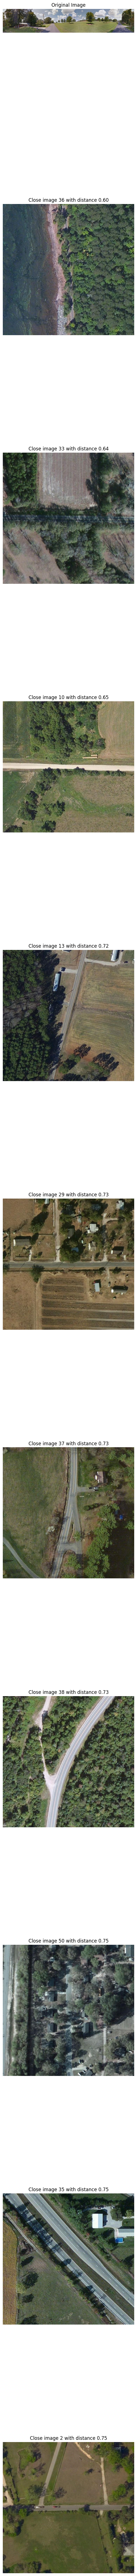

(tensor([[0.9706],
        [0.7899],
        [0.7501],
        [0.9174],
        [0.8735],
        [0.9158],
        [0.9023],
        [0.9144],
        [0.9566],
        [0.7526],
        [0.6541],
        [0.8532],
        [0.8906],
        [0.7174],
        [0.9350],
        [0.9582],
        [0.9640],
        [0.9054],
        [0.9849],
        [0.9570],
        [0.8369],
        [0.8558],
        [0.8600],
        [0.7874],
        [0.8714],
        [0.7630],
        [1.0036],
        [0.9151],
        [0.8524],
        [0.7300],
        [0.8056],
        [1.0164],
        [0.9110],
        [0.6393],
        [0.9105],
        [0.7483],
        [0.6016],
        [0.7319],
        [0.7349],
        [0.9742],
        [0.8230],
        [1.0275],
        [1.0103],
        [0.9479],
        [0.8184],
        [0.9114],
        [0.9580],
        [0.9429],
        [0.9143],
        [1.0843],
        [0.7466],
        [0.8722],
        [1.0150],
        [1.0085],
        [0.7785],
        [

In [103]:
print(model.search(data_module.dataset[1][0], data_module.dataset[:100][1], 10))